This notebook contains the code used in the BigComp 2022 paper: <br>
<b>Heeryon Cho, Woo-Kyu Kang, Younsoo Park, Sungeu Chae, and Seong-joon Kim, "Multi-label Facial Emotion Recognition Using Korean Drama Movie Clips," BigComp 2022.</b>
### Convert tfrecords into images & Analyze image labels

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install ipython-autotime

In [3]:
import os
import pandas as pd
import random as rn
import numpy as np
from collections import Counter
from IPython.display import display, Image
import tensorflow as tf

In [4]:
# Record cell run time.
#!pip install ipython-autotime

%load_ext autotime

time: 418 µs (started: 2022-05-09 11:20:04 +00:00)


## 1. Convert tfrecord file into images

In [5]:
# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([24], tf.int64),  # adjust the number with [6, 22, 24] labels (6_basic_emo, 22_emo, multi-label)
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

raw_image_dataset = tf.data.TFRecordDataset('/content/sample_data/multi-label_test.tfrecords')

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset element_spec={'depth': TensorSpec(shape=(), dtype=tf.int64, name=None), 'height': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image_raw': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(24,), dtype=tf.int64, name=None), 'width': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

time: 162 ms (started: 2022-05-09 11:20:04 +00:00)


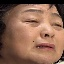

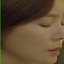

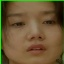

Number of images displayed: 3
time: 67.4 ms (started: 2022-05-09 11:20:04 +00:00)


In [6]:
n = 0
for image_features in parsed_image_dataset.take(3):
    image_raw = image_features['image_raw'].numpy()
    display(Image(data=image_raw))
    n += 1
print("Number of images displayed:", n)

## 2. Analyze emotion labels.

### Read emotion labels.

In [7]:
# Load labels, check headers, check data shape.

df_label = pd.read_csv('/content/sample_data/label_multi-label_test.csv')
print(df_label.columns)
print(df_label.shape)

LABELS = list(df_label.columns[2:])
print("LABELS=", LABELS)
print(len(LABELS))

Index(['img_id', 'clip_id', 'moved', 'fearful', 'bored', 'surprised', 'angry',
       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
       'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful',
       'happy', 'disgusted'],
      dtype='object')
(3882, 26)
LABELS= ['moved', 'fearful', 'bored', 'surprised', 'angry', 'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled', 'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed', 'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful', 'happy', 'disgusted']
24
time: 61.3 ms (started: 2022-05-09 11:20:04 +00:00)


In [8]:
# Place label data into a dictionary.

dict_label = {}
for idx, row in df_label.iterrows():
    dict_label[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label)

3882

time: 1.14 s (started: 2022-05-09 11:20:04 +00:00)


In [9]:
dict_label.keys()

dict_keys(['06_0001055_00003.jpg', '16_0032-19_00004.jpg', '03_0010-18_00069.jpg', '12_0002-33_00024.jpg', '12_0008-45_00011.jpg', '12_0007-22_00044.jpg', '22_0000913_00002.jpg', '03_0012-55_00031.jpg', '06_0000676_00023.jpg', '12_0006-48_00006.jpg', '06_0000491_00047.jpg', '12_0015-30_00024.jpg', '06_0000846_00008.jpg', '06_0000208_00032.jpg', '06_0000989_00004.jpg', '03_0009-44_00054.jpg', '12_0013-12_00003.jpg', '22_0000753_00006.jpg', '06_0001079_00007.jpg', '06_0000965_00028.jpg', '22_0000923_00021.jpg', '22_0000663_00010.jpg', '06_0000449_00005.jpg', '06_0000989_00030.jpg', '03_001-103_00008.jpg', '06_0000854_00016.jpg', '06_0000987_00023.jpg', '12_0002-82_00008.jpg', '03_0009-81_00018.jpg', '03_0010-88_00018.jpg', '12_0003-12_00002.jpg', '22_0000054_00020.jpg', '06_0000134_00038.jpg', '12_0011-21_00001.jpg', '12_0001-40_00010.jpg', '03_0002-87_00007.jpg', '03_0003-15_00006.jpg', '06_0000686_00020.jpg', '12_0004-57_00004.jpg', '16_0026-10_00001.jpg', '06_0000031_00033.jpg', '16_0

time: 9.87 ms (started: 2022-05-09 11:20:05 +00:00)


In [10]:
# Display one image label.

dict_label['06_0001055_00003.jpg']

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

time: 7.17 ms (started: 2022-05-09 11:20:05 +00:00)


In [11]:
# List unique labels.

uniq_labels = [list(x) for x in set(tuple(x) for x in list(dict_label.values()))]
uniq_labels.sort()
len(uniq_labels)

131

time: 20 ms (started: 2022-05-09 11:20:05 +00:00)


In [12]:
# Convert list-format labels into string-format labels.

uniq_labels_strs = [str(x) for x in list(dict_label.values())]
uniq_labels_strs[0]

'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'

time: 25.4 ms (started: 2022-05-09 11:20:05 +00:00)


In [13]:
# Count unique label frequency.

uniq_label_counts = Counter(uniq_labels_strs)
uniq_label_counts
sorted_uniq_label_counts = dict(sorted(uniq_label_counts.items()))
sorted_uniq_label_counts

{'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]': 8,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]': 23,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]': 15,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]': 25,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]': 17,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]': 38,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]': 38,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]': 6,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]': 2,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]': 43,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]': 93,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]': 1,
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

time: 17.1 ms (started: 2022-05-09 11:20:05 +00:00)


In [14]:
# Double check the total numbers.

sum(sorted_uniq_label_counts.values())

3882

time: 5.95 ms (started: 2022-05-09 11:20:05 +00:00)


In [15]:
# Select one unique label.

uniq_labels[3]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]

time: 5.41 ms (started: 2022-05-09 11:20:05 +00:00)


In [16]:
# Retrieve index where label value equals one.

all_indices = [i for i,x in enumerate(uniq_labels[3]) if x == 1]
all_indices

[21, 22]

time: 9.12 ms (started: 2022-05-09 11:20:05 +00:00)


In [17]:
# Retrieve emotion words using indices.

emotions = [LABELS[i] for i in all_indices]
emotions

['peaceful', 'happy']

time: 11 ms (started: 2022-05-09 11:20:05 +00:00)


### Count total number of labels with 1, 2, 3, and 4 emotions.

In [18]:
count_n_labels = []
count_1_emotion = []
count_1_emotion_sum = 0
count_2_emotion = []
count_2_emotion_sum = 0
count_3_emotion = []
count_3_emotion_sum = 0
count_4_emotion = []
count_4_emotion_sum = 0
count_multi_emotion = []
count_multi_emotion_sum = 0
for k, v in sorted_uniq_label_counts.items():
    str_list = k[1:-1].split(', ')
    label_list = [int(i) for i in str_list]
    all_indices = [i for i,x in enumerate(label_list) if x == 1]
    emotions = [LABELS[i] for i in all_indices]
    count_n_labels.append([v] + emotions)
    
    if len(emotions) == 1:
        count_1_emotion.append([v] + emotions)
        count_1_emotion_sum += v
    
    if len(emotions) == 2:
        count_2_emotion.append([v] + emotions)
        count_2_emotion_sum += v

    if len(emotions) == 3:
        count_3_emotion.append([v] + emotions)
        count_3_emotion_sum += v

    if len(emotions) == 4:
        count_4_emotion.append([v] + emotions)
        count_4_emotion_sum += v
        
    if len(emotions) > 1:
        count_multi_emotion.append([v] + emotions)
        count_multi_emotion_sum += v    
        
count_n_labels.sort(reverse=True)
print(len(count_n_labels))
count_n_labels

131


[[762, 'angry'],
 [275, 'surprised'],
 [188, 'upset'],
 [181, 'sad'],
 [175, 'sad', 'upset'],
 [158, 'sad', 'depressed'],
 [129, 'angry', 'upset'],
 [101, 'angry', 'sad'],
 [97, 'anxious'],
 [94, 'smitten', 'happy'],
 [93, 'sad', 'sympathetic'],
 [93, 'amused', 'happy'],
 [87, 'disappointed'],
 [74, 'upset', 'depressed'],
 [71, 'smitten', 'fluttered'],
 [57, 'angry', 'disgusted'],
 [55, 'angry', 'disappointed'],
 [54, 'sympathetic'],
 [53, 'disappointed', 'upset'],
 [48, 'upset', 'guilty'],
 [43, 'amused'],
 [40, 'moved'],
 [39, 'smitten', 'sympathetic'],
 [38, 'guilty'],
 [38, 'affectionate'],
 [36, 'disappointed', 'sad'],
 [31, 'angry', 'jealous'],
 [28, 'fearful'],
 [27, 'sad', 'guilty'],
 [26, 'smitten'],
 [25, 'peaceful', 'happy'],
 [23, 'happy'],
 [23, 'angry', 'guilty'],
 [21, 'depressed'],
 [20, 'sad', 'upset', 'depressed'],
 [20, 'fearful', 'surprised'],
 [19, 'surprised', 'upset'],
 [18, 'smitten', 'sad'],
 [18, 'fearful', 'anxious', 'passionate'],
 [17, 'sad', 'affectionate'

time: 50 ms (started: 2022-05-09 11:20:05 +00:00)


<b>1. Number of labels with one emotion only.</b>

In [19]:
count_1_emotion.sort(reverse=True)
print("--- 1 label total:", count_1_emotion_sum)
print("--- 1 label uniq:", len(count_1_emotion))
count_1_emotion

--- 1 label total: 1976
--- 1 label uniq: 22


[[762, 'angry'],
 [275, 'surprised'],
 [188, 'upset'],
 [181, 'sad'],
 [97, 'anxious'],
 [87, 'disappointed'],
 [54, 'sympathetic'],
 [43, 'amused'],
 [40, 'moved'],
 [38, 'guilty'],
 [38, 'affectionate'],
 [28, 'fearful'],
 [26, 'smitten'],
 [23, 'happy'],
 [21, 'depressed'],
 [17, 'jealous'],
 [15, 'peaceful'],
 [14, 'fulfilled'],
 [11, 'fluttered'],
 [8, 'disgusted'],
 [7, 'ashamed'],
 [3, 'passionate']]

time: 8.56 ms (started: 2022-05-09 11:20:05 +00:00)


<b>2. Number of labels with two emotions.</b>

In [20]:
count_2_emotion.sort(reverse=True)
print("--- 2 labels total:", count_2_emotion_sum)
print("--- 2 labels uniq:", len(count_2_emotion))
count_2_emotion

--- 2 labels total: 1818
--- 2 labels uniq: 89


[[175, 'sad', 'upset'],
 [158, 'sad', 'depressed'],
 [129, 'angry', 'upset'],
 [101, 'angry', 'sad'],
 [94, 'smitten', 'happy'],
 [93, 'sad', 'sympathetic'],
 [93, 'amused', 'happy'],
 [74, 'upset', 'depressed'],
 [71, 'smitten', 'fluttered'],
 [57, 'angry', 'disgusted'],
 [55, 'angry', 'disappointed'],
 [53, 'disappointed', 'upset'],
 [48, 'upset', 'guilty'],
 [39, 'smitten', 'sympathetic'],
 [36, 'disappointed', 'sad'],
 [31, 'angry', 'jealous'],
 [27, 'sad', 'guilty'],
 [25, 'peaceful', 'happy'],
 [23, 'angry', 'guilty'],
 [20, 'fearful', 'surprised'],
 [19, 'surprised', 'upset'],
 [18, 'smitten', 'sad'],
 [17, 'sad', 'affectionate'],
 [17, 'anxious', 'sad'],
 [16, 'smitten', 'amused'],
 [16, 'fearful', 'anxious'],
 [16, 'disappointed', 'jealous'],
 [13, 'fearful', 'sad'],
 [13, 'anxious', 'upset'],
 [13, 'angry', 'depressed'],
 [12, 'surprised', 'sad'],
 [11, 'sympathetic', 'guilty'],
 [11, 'sympathetic', 'affectionate'],
 [11, 'moved', 'sad'],
 [11, 'ashamed', 'sad'],
 [10, 'upset

time: 21.6 ms (started: 2022-05-09 11:20:05 +00:00)


<b>3. Number of labels with three emotions.</b>

In [21]:
count_3_emotion.sort(reverse=True)
print("--- 3 labels total:", count_3_emotion_sum)
print("--- 3 labels uniq:", len(count_3_emotion))
count_3_emotion

--- 3 labels total: 88
--- 3 labels uniq: 20


[[20, 'sad', 'upset', 'depressed'],
 [18, 'fearful', 'anxious', 'passionate'],
 [8, 'sad', 'sympathetic', 'affectionate'],
 [5, 'smitten', 'disappointed', 'affectionate'],
 [5, 'fearful', 'anxious', 'sad'],
 [5, 'disappointed', 'sad', 'upset'],
 [4, 'sad', 'upset', 'sympathetic'],
 [4, 'angry', 'sad', 'upset'],
 [3, 'sad', 'sympathetic', 'guilty'],
 [3, 'fearful', 'upset', 'guilty'],
 [2, 'smitten', 'fluttered', 'sympathetic'],
 [2, 'disappointed', 'sad', 'disgusted'],
 [2, 'anxious', 'fluttered', 'affectionate'],
 [1, 'smitten', 'fluttered', 'amused'],
 [1, 'smitten', 'amused', 'happy'],
 [1, 'moved', 'smitten', 'fluttered'],
 [1, 'anxious', 'upset', 'passionate'],
 [1, 'anxious', 'upset', 'happy'],
 [1, 'angry', 'upset', 'disgusted'],
 [1, 'angry', 'sad', 'guilty']]

time: 12.6 ms (started: 2022-05-09 11:20:05 +00:00)


<b>4. Number of labels with four emotions.</b>

In [22]:
count_4_emotion.sort(reverse=True)
print("--- 4 labels total:", count_4_emotion_sum)
print("--- 4 labels uniq:", len(count_4_emotion))
count_4_emotion

--- 4 labels total: 0
--- 4 labels uniq: 0


[]

time: 9.78 ms (started: 2022-05-09 11:20:05 +00:00)


In [23]:
count_multi_emotion.sort(reverse=True)
print("--- Multi-label total:", count_multi_emotion_sum)
print("--- Multi-label uniq:", len(count_multi_emotion))
count_multi_emotion

--- Multi-label total: 1906
--- Multi-label uniq: 109


[[175, 'sad', 'upset'],
 [158, 'sad', 'depressed'],
 [129, 'angry', 'upset'],
 [101, 'angry', 'sad'],
 [94, 'smitten', 'happy'],
 [93, 'sad', 'sympathetic'],
 [93, 'amused', 'happy'],
 [74, 'upset', 'depressed'],
 [71, 'smitten', 'fluttered'],
 [57, 'angry', 'disgusted'],
 [55, 'angry', 'disappointed'],
 [53, 'disappointed', 'upset'],
 [48, 'upset', 'guilty'],
 [39, 'smitten', 'sympathetic'],
 [36, 'disappointed', 'sad'],
 [31, 'angry', 'jealous'],
 [27, 'sad', 'guilty'],
 [25, 'peaceful', 'happy'],
 [23, 'angry', 'guilty'],
 [20, 'sad', 'upset', 'depressed'],
 [20, 'fearful', 'surprised'],
 [19, 'surprised', 'upset'],
 [18, 'smitten', 'sad'],
 [18, 'fearful', 'anxious', 'passionate'],
 [17, 'sad', 'affectionate'],
 [17, 'anxious', 'sad'],
 [16, 'smitten', 'amused'],
 [16, 'fearful', 'anxious'],
 [16, 'disappointed', 'jealous'],
 [13, 'fearful', 'sad'],
 [13, 'anxious', 'upset'],
 [13, 'angry', 'depressed'],
 [12, 'surprised', 'sad'],
 [11, 'sympathetic', 'guilty'],
 [11, 'sympathetic'

time: 25.8 ms (started: 2022-05-09 11:20:05 +00:00)


In [24]:
# Double check total count.

total_count = count_1_emotion_sum + count_2_emotion_sum + count_3_emotion_sum + count_4_emotion_sum
total_count

3882

time: 5.26 ms (started: 2022-05-09 11:20:05 +00:00)


In [25]:
# Double check unique emotion labels.

total_uniq_emotion = len(count_1_emotion) + len(count_2_emotion) + len(count_3_emotion) + len(count_4_emotion)
total_uniq_emotion

131

time: 5.66 ms (started: 2022-05-09 11:20:05 +00:00)
